### **Transfer Learning - Scaling Up**

* Here we will try to scale up from 10 classes to 101 classes of food.
* Our goal is to beat Food 101 paper using 10% of training data (leveraging the power of deep learning)
  * Original paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf (50.76% accuracy across 101 classes)

In [ ]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

2025-03-14 15:02:40.683899: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**1. Training a model to fit data of 101 classes of Food101 dataset**

**Steps in model building**

* Create a model checkpoint callback
* Create data augmentation layer to build augmentation right into the model
* Build a headless (no-top layers) Functional EfficientNetB0 backboned model
* Create our own output layer
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and 15%  of test data, to save epoch time)

**Note:**
I have trained the model using google-colab to use GPU resources, and then transfered the checkpoints, and best saved model

**Dataset:**<br>
Food101 10% dataset:<br>
https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

In [4]:
data_dir='101_food_classes_10_percent'
train_dir = f'{data_dir}/train/'
test_dir = f'{data_dir}/test/'

import sys
sys.path.append("/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/")
import important_functionalities as impf

In [6]:
impf.walkthrough_directories(data_dir)

There are 2 directories and 0 images in 101_food_classes_10_percent
There are 101 directories and 0 images in 101_food_classes_10_percent/test
There are 0 directories and 250 images in 101_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 101_food_classes_10_percent/test/takoyaki
There are 0 directories and 250 images in 101_food_classes_10_percent/test/cheesecake
There are 0 directories and 250 images in 101_food_classes_10_percent/test/creme_brulee
There are 0 directories and 250 images in 101_food_classes_10_percent/test/macarons
There are 0 directories and 250 images in 101_food_classes_10_percent/test/baklava
There are 0 directories and 250 images in 101_food_classes_10_percent/test/onion_rings
There are 0 directories and 250 images in 101_food_classes_10_percent/test/clam_chowder
There are 0 directories and 250 images in 101_food_classes_10_percent/test/beef_carpaccio
There are 0 directories and 250 images in 101_food_classes_10_percent/test/tacos
T

In [7]:
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
train_data=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                               image_size=IMAGE_SHAPE,
                                                               label_mode='categorical',
                                                                batch_size=BATCH_SIZE
                                                               )
valid_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                               image_size=IMAGE_SHAPE,
                                                                label_mode='categorical',
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False
                                                                ) # currently don't shuffle the data, will help to evaluate better

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
# 1. creating model checkpoint callback
checkpoint_path='101_classes_10_percent_data_model_checkpoints/checkpoints.weights.h5'
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    monitor='val_accuracy',
                                                    save_best_only=True,
                                                    verbose=1)

In [9]:
# 2. creating a data-augmentation layer to put it right into the model
data_augmentation=kr.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    # tf.keras.layers.Rescaling(1/255.0) # rescaling not-needed for efficient net
], name='data_augmentation')

In [ ]:
# 3. Build a headless (no top layers) Functional EfficientNetB0 model
input_shape=(224,224,3)
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape, 
)

base_model.trainable=False

# 4. Setup model architecture with trainable top
inputs=tf.keras.layers.Input(shape=input_shape, name='input_layer')
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
output=tf.keras.layers.Dense(len(train_data.class_names),activation='softmax',name='output_layer')(x)

model=tf.keras.Model(inputs,output)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,048,693 (23.07 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
# 5. Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
# 6. Feature extract for 5 full passes:
initial_epochs=5
history_10_percent_101_classes=model.fit(train_data,
                               epochs=initial_epochs,
                               steps_per_epoch=len(train_data),
                               validation_data=valid_data,
                               validation_steps=int(0.15*len(valid_data)),
                               callbacks=[model_checkpoint])

**loading using checkpoints**

In [11]:
# 5. Loading weights from checkpoint for feature extraction model
model.load_weights(checkpoint_path)

In [12]:
# 6. Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [13]:
# 7. fine-tuning 

### unfreeze all layers
base_model.trainable=True

### Freeze all layers except last 5 layers
layer_count=5
for layer in base_model.layers[:-layer_count]:
  layer.trainable=False

In [14]:
checkpoint_path='101_classes_10_percent_data_model_checkpoints/fine_tuned_checkpoints.weights.h5'

In [ ]:
fine_tune_epochs = initial_epochs + 5 # model has already done 5 epochs (we're going to fine-tune for 6 more)

# refit the model (same as model_2 except with more trainable layers)
history_10_percent_101_classes_fine_tuned=model.fit(train_data,
                                        epochs=fine_tune_epochs,
                                        steps_per_epoch=len(train_data),
                                        validation_data=valid_data,
                                        validation_steps=int(0.25*len(valid_data)),
                                        initial_epoch=history_10_percent_101_classes.epoch[-1], # start from previous last epoch
                                        callbacks=[model_checkpoint])

**loading the best trained model**

In [15]:
model_1=tf.keras.models.load_model('best_model_food101.keras')

**2. Evaluating the fitted model**

In [16]:
model_1.evaluate(valid_data)

2025-03-14 17:24:06.065051: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2025-03-14 17:24:06.116804: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2025-03-14 17:24:06.141436: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2025-03-14 17:24:06.164709: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2025-03-14 17:24:06.175658: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.


790/790 ━━━━━━━━━━━━━━━━━━━━ 520s 654ms/step - accuracy: 0.5807 - loss: 1.5958


[1.4834662675857544, 0.6036831736564636]

In [ ]:
### Evaluating performance of best_model across all different classes 
pred_probs = model_1.predict(valid_data, verbose=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 565s 714ms/step


In [41]:
len(pred_probs)

25250

In [42]:
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([85,  0, 41,  0,  8, 78, 29, 46,  9, 41])

In [43]:
# getting test labels (by unravelling valid_data)
test_labels=[]
for _,labels in valid_data.unbatch().as_numpy_iterator():
    test_labels.append(labels.argmax())

2025-03-14 18:13:02.159482: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
len(test_labels)

25250

In [44]:
# comparing model's prediction (by finding accuracy)
from sklearn.metrics import accuracy_score
accuracy_score(test_labels,pred_classes)

0.6036831683168317

In [48]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_conf_mat(y_true,y_pred,figsize = (4,4),classes = None,title_size = 15 ,label_size = 10, text_size = 8,savefig = False):

    conf_mat=confusion_matrix(y_true,y_pred)
    cm_norm=conf_mat.astype("float") / conf_mat.sum(axis=1)[:,np.newaxis] # normalize confusion matrix
    n_classes = conf_mat.shape[0]

    fig,ax=plt.subplots(figsize=figsize)

    # create a matrix plot
    cax=ax.matshow(conf_mat,cmap=plt.cm.Blues) 
    fig.colorbar(cax)

    # Create classes
    if classes:
        labels = classes
    else:
        labels=np.arange(conf_mat.shape[0])

    # label the axes
    ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
        )

    # getting the x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    # plotting the x-axis labels vertically
    ax.xaxis.set_tick_params(rotation=70)

    # adjust label size
    ax.yaxis.label.set_size(label_size)
    ax.xaxis.label.set_size(label_size)

    # adjust title size
    ax.title.set_size(title_size)

    # set the threshold for different colors
    threshold = (conf_mat.max() + conf_mat.min())/2.0

    # plot the text on each cell 
    for i,j in itertools.product(range(conf_mat.shape[0]),range(conf_mat.shape[1])):
        plt.text(j,i,f"{conf_mat[i,j]}\n({cm_norm[i,j]*100:.2f}%)",
                horizontalalignment = "center",
                verticalalignment = "center",
                color = "white" if conf_mat[i,j]>threshold else "black",
                size = text_size)
    
    if savefig:
        plt.savefig("confusion_matrix.png")
    plt.show()


In [ ]:
plot_conf_mat(test_labels,pred_classes,figsize=(100,100),classes=class_names,savefig=True,label_size=20,text_size=12,title_size=30)

In [52]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,pred_classes,target_names=class_names))

                         precision    recall  f1-score   support

              apple_pie       0.38      0.15      0.22       250
         baby_back_ribs       0.60      0.69      0.64       250
                baklava       0.72      0.54      0.62       250
         beef_carpaccio       0.68      0.59      0.63       250
           beef_tartare       0.59      0.43      0.50       250
             beet_salad       0.57      0.42      0.49       250
               beignets       0.74      0.76      0.75       250
               bibimbap       0.81      0.74      0.77       250
          bread_pudding       0.30      0.52      0.38       250
      breakfast_burrito       0.35      0.78      0.49       250
             bruschetta       0.46      0.52      0.49       250
           caesar_salad       0.61      0.60      0.60       250
                cannoli       0.75      0.58      0.66       250
          caprese_salad       0.57      0.56      0.56       250
            carrot_cake 

**3. Visualizing f1-scores for different classes**

In [63]:
# getting dictationary using classification report
classification_report_dict=classification_report(test_labels,pred_classes,target_names=class_names,output_dict=True)
classification_report_dict

# creating dictationary with class names and f1 scores
class_f1_scores={}
for k,v in classification_report_dict.items():
    if k=='accuracy':
        break
    else:
        class_f1_scores[k]=v['f1-score']


In [74]:
# turn f1-scores into dataframe for visualization
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),'f1_scores': list(class_f1_scores.values())}).sort_values('f1_scores',ascending=False)
f1_scores[:10]

class_names  f1_scores
33            edamame   0.961240
69            oysters   0.844898
88      seaweed_salad   0.841202
63           macarons   0.839002
32          dumplings   0.835590
54  hot_and_sour_soup   0.834915
86            sashimi   0.828685
65            mussels   0.826552
45      frozen_yogurt   0.818004
75                pho   0.816697

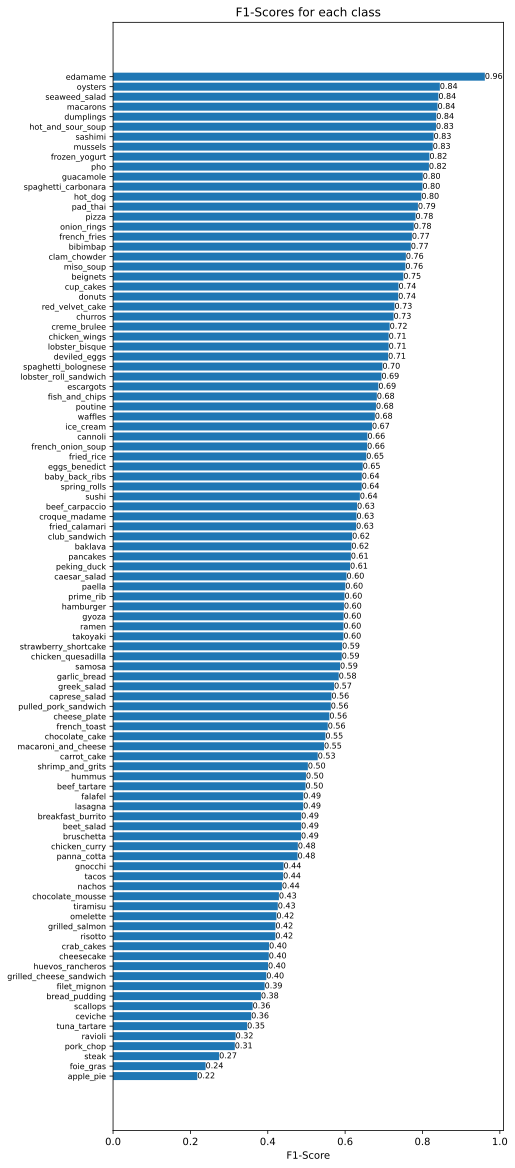

In [98]:
# plotting f1-scores vs class names
fig, ax = plt.subplots(figsize=(7, 20))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1_scores'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'], fontsize=8)
ax.set_xlabel("F1-Score")
ax.set_title("F1-Scores for each class")
ax.invert_yaxis()

# Adding labels
ax.bar_label(scores, fmt='%.2f', padding=0, fontsize=8, label_type='edge')

plt.show()

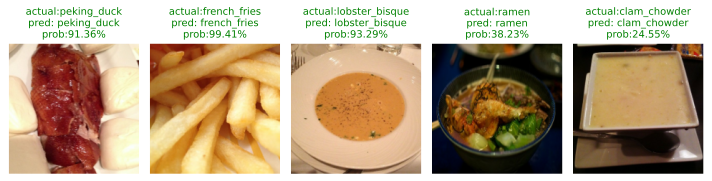

In [119]:
### visualizing predictions on test images
def load_preprocess(filename,img_shape=(224,224),scale=False,expand_dims=True):
    img=tf.io.read_file(filename)
    img=tf.image.decode_image(img)
    img=tf.image.resize(img,size=img_shape)
    if scale:
        img=img/255.0
    if expand_dims:
        img=tf.expand_dims(img,0)
    return img

import random
import os
def predict(img_dir,model,n_images=3):
    plt.figure(figsize=(10,8))
    for i in range(n_images):
        class_name=random.choice(class_names)
        filename=random.choice(os.listdir(img_dir+"/"+class_name))
        img=load_preprocess(img_dir+"/"+class_name+"/"+filename,scale=False,expand_dims=True)
        pred_prob=model.predict(img,verbose=0)
        pred_class=class_names[pred_prob.argmax()]
        
        # plotting:
        plt.subplot(1,n_images,i+1)
        plt.imshow(tf.squeeze(img)/255.0)
        if class_name==pred_class:
            color='green'
        else:
            color='red'
        plt.title(f'actual:{class_name}\npred: {pred_class}\nprob:{pred_prob.max()*100:.2f}%',color=color,fontsize=10)
        plt.axis('off')
        plt.tight_layout()
        # plt.show() 

predict(test_dir,model_1,n_images=5)

**4. Checking out where our model is most wrong**

* A good way to inspect model's performance is to view the wrong predictions with the highest prediction probability (or highest loss)
* Can reveal insights such as:
  * Data issues (wrong labels, eg: model is right, label is wrong)
  * Confusing classes (get better/more diverse data)
* Steps:
  * Get all of the image file paths in the test dataset using `tf.list_files()` method.
  * Create a pandas Dataframe of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities.
  * Use our Dataframe to find all the wrong predictions (where the ground truth doesn't match with the prediction).
  * Sort the dataframe based on wrong predictions (have the highest prediction probabilities).
  * Visualize the images with highest prediction probabilities but we have wrong prediction.


In [121]:
valid_data.list_files(test_dir)

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [126]:
test_dir+'*/*.jpg'

'101_food_classes_10_percent/test/*/*.jpg'

In [ ]:
#1. Getting all of the image filepaths in test dataset
file_paths=[]
for filepath in valid_data.list_files(test_dir+'*/*.jpg',shuffle=False):
    file_paths.append(filepath.numpy())


#2. Creating a pred_df dataframe
### already obtained these on top:
### getting test labels (by unravelling valid_data)
# test_labels=[]
# for _,labels in valid_data.unbatch().as_numpy_iterator():
#     test_labels.append(labels.argmax())

### Evaluating performance of best_model across all different classes and find out which predictions are most wrong
# pred_probs = model_1.predict(valid_data, verbose=1)

class_names = train_data.class_names
# pred_classes = pred_probs.argmax(axis=1)

pred_df=pd.DataFrame({
    'img_path':file_paths,
    'y_true':np.array(test_labels),
    'y_true_class':np.array([class_names[i] for i in test_labels]),
    'y_pred':pred_classes,
    'y_pred_class':np.array([class_names[i] for i in pred_classes]),
    'max_pred_prob':pred_probs.max(axis=1),
}
)
pred_df

2025-03-15 18:26:11.935697: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


img_path  y_true y_true_class  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0    apple_pie   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0    apple_pie   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0    apple_pie   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0    apple_pie   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0    apple_pie   
...                                                  ...     ...          ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100      waffles   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      waffles   
25247  b'101_food_classes_10_percent/test/waffles/961...     100      waffles   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      waffles   
25249  b'101_food_classes_10_percent/test/waffles/971...     100      waffles   

       y_pred       y_pred_class  max_pred_prob  
0          85             samosa       0.452634  
1           0          apple_pie       0.472689  
2          41  french_onion_soup       0.245054  
3           0          apple_pie       0.344468  
4           8      bread_pudding       0.520022  
...       ...                ...            ...  
25245     100            waffles       0.833922  
25246     100            waffles       0.894483  
25247      56   huevos_rancheros       0.371819  
25248     100            waffles       0.261398  
25249      52              gyoza       0.195287  

[25250 rows x 6 columns]

In [132]:
# 3. Find out in our dataframe which predictions were most wrong
pred_df['pred_correct']=pred_df['y_true']==pred_df['y_pred']
pred_df.head()

img_path  y_true y_true_class  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0    apple_pie   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0    apple_pie   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0    apple_pie   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0    apple_pie   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0    apple_pie   

   y_pred       y_pred_class  max_pred_prob  pred_correct  
0      85             samosa       0.452634         False  
1       0          apple_pie       0.472689          True  
2      41  french_onion_soup       0.245054         False  
3       0          apple_pie       0.344468          True  
4       8      bread_pudding       0.520022         False

In [ ]:
# 4. sort our dataframe to have most wrong predictions at the top
top_wrong=pred_df[pred_df['pred_correct']==False].sort_values('max_pred_prob',ascending=False)
top_wrong

img_path  y_true  \
23797  b'101_food_classes_10_percent/test/sushi/16593...      95   
14062  b'101_food_classes_10_percent/test/huevos_ranc...      56   
4836   b'101_food_classes_10_percent/test/chicken_que...      19   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72   
14482  b'101_food_classes_10_percent/test/hummus/8476...      57   
...                                                  ...     ...   
14379  b'101_food_classes_10_percent/test/hummus/3034...      57   
21773  b'101_food_classes_10_percent/test/scallops/13...      87   
10807  b'101_food_classes_10_percent/test/fried_calam...      43   
7571   b'101_food_classes_10_percent/test/deviled_egg...      30   
23931  b'101_food_classes_10_percent/test/sushi/39947...      95   

             y_true_class  y_pred       y_pred_class  max_pred_prob  \
23797               sushi      86            sashimi       0.986679   
14062    huevos_rancheros      28      croque_madame       0.986606   
4836   chicken_quesadilla       9  breakfast_burrito       0.985241   
18001            pancakes      67           omelette       0.980970   
14482              hummus      51          guacamole       0.980861   
...                   ...     ...                ...            ...   
14379              hummus      93              steak       0.078291   
21773            scallops      39          foie_gras       0.077442   
10807      fried_calamari      34      eggs_benedict       0.077126   
7571         deviled_eggs      73        panna_cotta       0.073804   
23931               sushi      56   huevos_rancheros       0.073743   

       pred_correct  
23797         False  
14062         False  
4836          False  
18001         False  
14482         False  
...             ...  
14379         False  
21773         False  
10807         False  
7571          False  
23931         False  

[10007 rows x 7 columns]

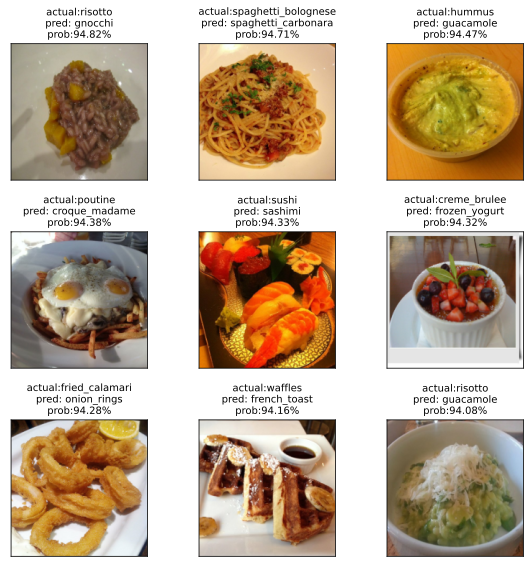

In [149]:
# 5. visualize the most wrong predictions (top 10)
### visualizing predictions on test images
def load_preprocess(filename,img_shape=(224,224),scale=False,expand_dims=True):
    img=tf.io.read_file(filename)
    img=tf.image.decode_image(img)
    img=tf.image.resize(img,size=img_shape)
    if scale:
        img=img/255.0
    if expand_dims:
        img=tf.expand_dims(img,0)
    return img

n_images=9
index_inc=18
fig,axs=plt.subplots(3,int(n_images/3),figsize=(8,8))
for i,ax in enumerate(axs.flatten()):
    img_path=top_wrong.iloc[i+index_inc]['img_path']
    y_true=top_wrong.iloc[i+index_inc]['y_true_class']
    y_pred=top_wrong.iloc[i+index_inc]['y_pred_class']
    pred_prob=top_wrong.iloc[i+index_inc]['max_pred_prob']
    img=load_preprocess(img_path,scale=False,expand_dims=True)

    # plotting
    ax.imshow(tf.squeeze(img)/255.0)
    ax.set_title(f'actual:{y_true}\npred: {y_pred}\nprob:{pred_prob*100:.2f}%',fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show() 

**5. Prediction on custom images**

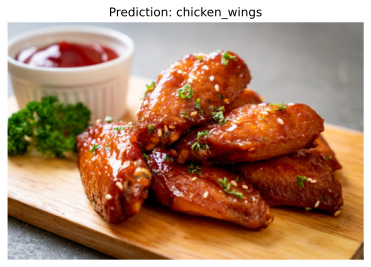

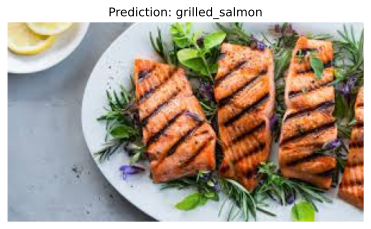

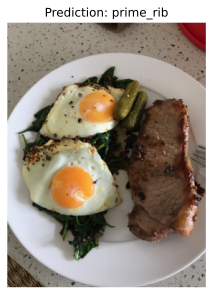

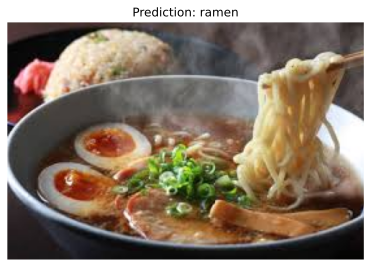

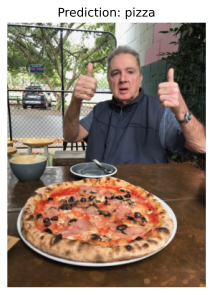

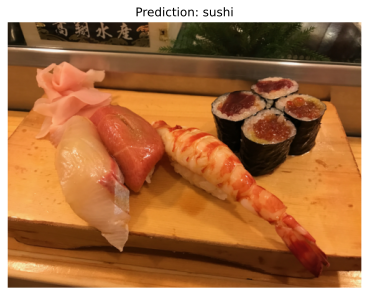

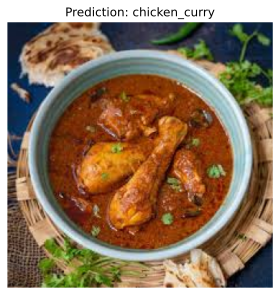

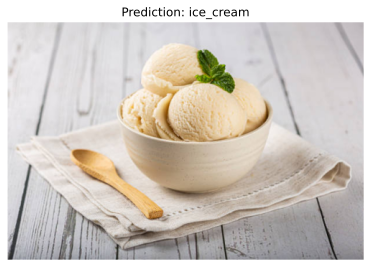

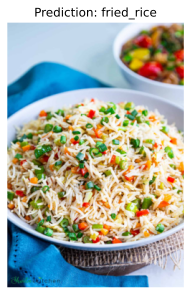

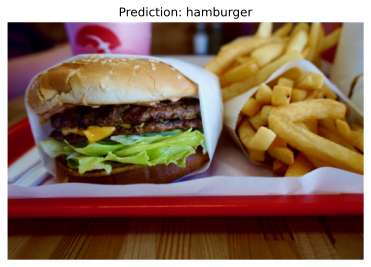

In [151]:
def pred_plot(model,filename,class_names):
    img=load_preprocess(filename)
    prediction=class_names[tf.argmax(tf.squeeze(model.predict(img,verbose=0)))]  
    plt.imshow(tf.squeeze(plt.imread(filename)))
    plt.title(f'Prediction: {prediction}')
    plt.axis('off')
    plt.show() 

import os 
cus_path='/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/5_convolutional_neural_network/10_food_classes_all_data'
for file in os.listdir(f'{cus_path}/custom_images'):
    pred_plot(model_1,f'{cus_path}/custom_images/{file}',train_data.class_names)